In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

from textwrap import wrap

from copy import deepcopy

In [2]:
training_data = 'abcdefghijklmnopqrstuvwxyz'*200

chars = set(list(training_data))

vocab_size = len(chars)

char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

print(f'{vocab_size} unique characters')
print(f'{len(training_data)} total characters')

26 unique characters
5200 total characters


In [39]:
hidden_size = 30

seq_length = 10

print(f'LSTM with {hidden_size} hidden units')
print(f'Will train on character sequences of length {seq_length}')
print()
txt = wrap(training_data[len(training_data)//2:(len(training_data)//2)+200])
txt = [line.center(100) for line in txt]
txt = '\n'.join(txt)
print('Training data sample: \n')
print(sample)
print()

LSTM with 30 hidden units
Will train on character sequences of length 10

Training data sample: 

                 e forceful dart Sung on, and pierced Amphimachus’s heart, Cteatus’                 
                son, of Neptune’s forceful line; Vain was his courage, and his race                 
                 divine! Prostrate he falls; his clanging arms resound, And his br                  



In [4]:
def initialize_weights(key,n_h,n_x):
    
    subkeys=random.split(key)

    params = dict()

    params['Wxc'] = random.normal(subkeys[0],(n_h,n_x))*0.01 # input to cell state
    params['Wxu'] = random.normal(subkeys[1],(n_h,n_x))*0.01 # input to update
    params['Wxf'] = random.normal(subkeys[2],(n_h,n_x))*0.01 # input to forget
    params['Wxo'] = random.normal(subkeys[3],(n_h,n_x))*0.01 # input to output

    params['bc'] = jnp.zeros((n_h, 1)) # hidden bias
    params['bu'] = jnp.zeros((n_h, 1)) # forget bias
    params['bf'] = jnp.zeros((n_h, 1)) # update bias
    params['bo'] = jnp.zeros((n_h, 1)) # output bias

    params['Whc'] = random.normal(subkeys[4],(n_h,n_h))*0.01 # hidden to cell
    params['Whu'] = random.normal(subkeys[5],(n_h,n_h))*0.01 # hidden to update
    params['Whf'] = random.normal(subkeys[6],(n_h,n_h))*0.01 # hidden to forget
    params['Who'] = random.normal(subkeys[7],(n_h,n_h))*0.01 # hidden to output

    params['Why'] = random.normal(subkeys[8],(n_x,n_h))*0.01 # hidden to output
    params['by'] = jnp.zeros((n_x, 1)) # output bias

    grad_mems = dict()
    sqrd_mems = dict()

    for parameter in params.keys():

        shape = params[parameter].shape

        grad_mems[parameter]=jnp.zeros(shape)
        sqrd_mems[parameter]=jnp.zeros(shape)

    return params, grad_mems, sqrd_mems

In [5]:
start_key = random.PRNGKey(0)

params,grad_mems,sqrd_mems = initialize_weights(start_key,hidden_size,vocab_size)

print(params.keys())
print(jnp.mean(params['Wxc']))
print(jnp.mean(grad_mems['Wxc']))
print(jnp.mean(sqrd_mems['Wxc']))

dict_keys(['Wxc', 'Wxu', 'Wxf', 'Wxo', 'bc', 'bu', 'bf', 'bo', 'Whc', 'Whu', 'Whf', 'Who', 'Why', 'by'])
-0.0005330194
0.0
0.0


In [6]:
def get_mini_batch(mini_batch_size,seq_length,char_to_ix,data):
    '''
    generator to continuous loop the data and pull out mini batches
    '''
    p = 0

    batch_character_size = mini_batch_size*(seq_length)

    while True:

        if p+batch_character_size+1>=len(data):
            p=0

            # need to reset hprev,cprev if it loops?

        inputs,targets = [],[]

        for _ in range(mini_batch_size):

            inputs.append([char_to_ix[ch] for ch in data[p:p+seq_length]])
            targets.append([char_to_ix[ch] for ch in data[p+1:p+seq_length+1]])

            p += seq_length

        inputs = jnp.array(inputs)
        targets = jnp.array(targets)

        yield inputs,targets

In [7]:
batch_gen = get_mini_batch(4,seq_length,char_to_ix,training_data)

inp,targ = next(batch_gen)

display(inp,targ)

Array([[19, 17,  8, 13,  7, 21,  3,  6,  2,  0],
       [15, 20, 16, 14, 11,  9, 25, 22, 10, 23],
       [24,  4,  5, 12,  1, 18, 19, 17,  8, 13],
       [ 7, 21,  3,  6,  2,  0, 15, 20, 16, 14]], dtype=int32)

Array([[17,  8, 13,  7, 21,  3,  6,  2,  0, 15],
       [20, 16, 14, 11,  9, 25, 22, 10, 23, 24],
       [ 4,  5, 12,  1, 18, 19, 17,  8, 13,  7],
       [21,  3,  6,  2,  0, 15, 20, 16, 14, 11]], dtype=int32)

In [8]:
def sigmoid(z):
    return 1.0/(1.0 + jnp.exp(-z))

def softmax(y):
    return jnp.exp(y) / jnp.sum(jnp.exp(y),axis=0)

def lstm_forward(inputs,targets,hprev,cprev,params):
    '''
    single forward pass of the LSTM

    returns loss for this mini-batch

    returns cache of variables needed for backwards pass
    '''

    # dims
    mini_batch_size = inputs.shape[0]
    seq_length = inputs.shape[1]

    hidden_size = hprev.shape[0]

    vocab_size = params['Wxc'].shape[1]

    # unpack params

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    Why = params['Why']
    by = params['by']

    # caches for forward pass

    xs, hs, cs, c_tildes = {}, {}, {}, {}

    gamma_us, gamma_fs, gamma_os = {}, {}, {}

    ys, ps = {},{}

    hs[-1] = jnp.tile(hprev,(1,mini_batch_size))
    cs[-1] = jnp.tile(cprev,(1,mini_batch_size))

    loss = 0

    for t in range(seq_length):
        xs[t] = jnp.zeros((vocab_size,mini_batch_size))

        xs[t] = xs[t].at[inputs[:,t],jnp.arange(mini_batch_size)].set(1) # batch of one-hot vectors for time t

        zc = jnp.dot(Wxc,xs[t]) + jnp.dot(Whc,hs[t-1]) + bc  # linear activation for candidate cell state C~
        zu = jnp.dot(Wxu,xs[t]) + jnp.dot(Whu,hs[t-1]) + bu  # linear activation for update gate
        zf = jnp.dot(Wxf,xs[t]) + jnp.dot(Whf,hs[t-1]) + bf  # linear activation for forget gate
        zo = jnp.dot(Wxo,xs[t]) + jnp.dot(Who,hs[t-1]) + bo  # linear activation for output gate

        c_tildes[t] = jnp.tanh(zc) # canidate for new c state

        gamma_us[t] = sigmoid(zu)
        gamma_fs[t] = sigmoid(zf)
        gamma_os[t] = sigmoid(zo)

        cs[t] = jnp.tanh(jnp.multiply(c_tildes[t],gamma_us[t]) + jnp.multiply(cs[t-1],gamma_fs[t]))  # tanh here is import!!!

        hs[t] = jnp.multiply(cs[t],gamma_os[t]) # hidden state

        ys[t] = jnp.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars

        ps[t] = softmax(ys[t]) # probabilities for next chars

        loss += -jnp.mean(jnp.log(ps[t][targets[:,t],jnp.arange(mini_batch_size)]))   #  ps[t] should be shape (vocab_size,mini_batch_size)

    p_cache = (ys,ps)

    gates = (gamma_us,gamma_fs,gamma_os)

    states = (xs,hs,cs,c_tildes)

    return loss, p_cache, gates, states

In [9]:
h = jnp.zeros((hidden_size,1))
c = jnp.zeros((hidden_size,1))

test_loss, p_cache, g_cache, s_cache = lstm_forward(inp,targ,h,c,params)

In [10]:
test_loss

Array(32.581303, dtype=float32)

In [11]:
print(type(p_cache),len(p_cache))
print(type(g_cache),len(g_cache))
print(type(s_cache),len(s_cache))

<class 'tuple'> 2
<class 'tuple'> 3
<class 'tuple'> 4


In [12]:
%timeit lstm_forward(inp,targ,h,c,params)[0].block_until_ready()

153 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
lstm_forward_jit = jit(lstm_forward)

#warmup
lstm_forward_jit(inp,targ,h,c,params)[0].block_until_ready()

%timeit lstm_forward_jit(inp,targ,h,c,params)[0].block_until_ready()

647 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
150*1000/583

257.28987993138935

In [15]:

def lstm_backward(targets,probs_cache,gates_cache,states_cache,params):
    '''
    backward pass of the LSTM

    return gradients for all parameters
    '''
    #unpack caches

    ys,ps = probs_cache

    gamma_us,gamma_fs,gamma_os = gates_cache

    xs,hs,cs,c_tildes = states_cache

    # dims
    mini_batch_size = targets.shape[0]
    seq_length = targets.shape[1]

    hidden_size = hs[-1].shape[0]

    vocab_size = params['Wxc'].shape[1]

    # unpack parameters

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    Why = params['Why']
    by = params['by']

    #initialize gradients to zero

    dWxc,dWxu,dWxf,dWxo = jnp.zeros_like(Wxc), jnp.zeros_like(Wxu), jnp.zeros_like(Wxf), jnp.zeros_like(Wxo)
    dWhc,dWhu,dWhf,dWho = jnp.zeros_like(Whc), jnp.zeros_like(Whu), jnp.zeros_like(Whf), jnp.zeros_like(Who)
    dbc,dbu,dbf,dbo = jnp.zeros_like(bc), jnp.zeros_like(bu), jnp.zeros_like(bf), jnp.zeros_like(bo)
    dWhy,dby = jnp.zeros_like(Why), jnp.zeros_like(by)

    # tmp variables to accumulate gradients over the backprop -- see differentiation graph
    dhnext, dcnext = jnp.zeros_like(hs[0]), jnp.zeros_like(cs[0])

    #backward pass

    for t in reversed(range(seq_length)):
        dy = jnp.copy(ps[t])

        dy = dy.at[targets[:,t],jnp.arange(mini_batch_size)].add(-1) #backprop into y

        dWhy += jnp.dot(dy, hs[t].T)
        dby += jnp.sum(dy,axis=1,keepdims=True)

        dh = jnp.dot(Why.T, dy) + dhnext # backprop into h

        dc = jnp.multiply((1-cs[t]**2),jnp.multiply(gamma_os[t],dh) + dcnext) #backprop into c

        dcnext = jnp.multiply(gamma_fs[t],dc)

        dzc = jnp.multiply((1-c_tildes[t]**2),jnp.multiply(gamma_us[t],dc))  # backprop through tanh

        dzu = jnp.multiply(gamma_us[t]*(1-gamma_us[t]),jnp.multiply(c_tildes[t],dc))  # sigmoid prime

        dzf = jnp.multiply(gamma_fs[t]*(1-gamma_fs[t]),jnp.multiply(cs[t-1],dc))

        dzo = jnp.multiply(gamma_os[t]*(1-gamma_os[t]),jnp.multiply(cs[t],dh))

        dbc += jnp.sum(dzc,axis=1,keepdims=True)
        dbu += jnp.sum(dzu,axis=1,keepdims=True)
        dbf += jnp.sum(dzf,axis=1,keepdims=True)
        dbo += jnp.sum(dzo,axis=1,keepdims=True)

        dWhc += jnp.dot(dzc,hs[t-1].T)
        dWhu += jnp.dot(dzu,hs[t-1].T)
        dWhf += jnp.dot(dzf,hs[t-1].T)
        dWho += jnp.dot(dzo,hs[t-1].T)

        dWxc += jnp.dot(dzc,xs[t].T)
        dWxu += jnp.dot(dzu,xs[t].T)
        dWxf += jnp.dot(dzf,xs[t].T)
        dWxo += jnp.dot(dzo,xs[t].T)

        # four contributions to dhnext,one from each gate
        dhnext = jnp.dot(Whc.T,dzc) + jnp.dot(Whu.T,dzu) + jnp.dot(Whf.T,dzf) + jnp.dot(Who.T,dzo)

    grads = dict()

    grads['Wxc']=dWxc
    grads['Wxu']=dWxu
    grads['Wxf']=dWxf
    grads['Wxo']=dWxo

    grads['Whc']=dWhc
    grads['Whu']=dWhu
    grads['Whf']=dWhf
    grads['Who']=dWho

    grads['bc']=dbc
    grads['bu']=dbu
    grads['bf']=dbf
    grads['bo']=dbo

    grads['Why']=dWhy
    grads['by']=dby

    for parameter in grads.keys():
        grads[parameter] = jnp.clip(grads[parameter], -5, 5) # clip to mitigate exploding gradients

    return grads

In [16]:
grads_test = lstm_backward(targ,p_cache,g_cache,s_cache,params)

print(type(grads_test),len(grads_test))

<class 'dict'> 14


In [29]:

def sgd_step_adam(current_step,inputs,targets,h,c,params,grads_mems,sqrd_mems,beta1,beta2,learning_rate):

    # dims
    mini_batch_size = inputs.shape[0]
    seq_length = inputs.shape[1]

    hidden_size = h.shape[0]

    vocab_size = params['Wxc'].shape[1]

    n = current_step

    #forward pass
    loss, p_cache, g_cache, s_cache = lstm_forward(inputs,targets,h,c,params)
    
    #need hs, cs

    xs,hs,cs,c_tildes = s_cache

    h_next = jnp.mean(hs[seq_length-1],axis=1,keepdims=True)
    c_next = jnp.mean(cs[seq_length-1],axis=1,keepdims=True)

    new_params = deepcopy(params)

    new_mems1 = deepcopy(grads_mems)
    new_mems2 = deepcopy(sqrd_mems)

    #backward pass
    grads = lstm_backward(targets,p_cache,g_cache,s_cache,params)

    # perform parameter update with ADAM 
    for parameter in new_params.keys():

        dparam = grads[parameter] / mini_batch_size

        new_mems1[parameter] = beta1*new_mems1[parameter] + (1-beta1)*dparam

        new_mems2[parameter] = beta2*new_mems2[parameter] + (1-beta2)*dparam*dparam

        grad_hat = new_mems1[parameter] / (1-beta1**(n+1))
        sqrd_hat = new_mems2[parameter] / (1-beta2**(n+1))

        new_params[parameter] += -learning_rate * grad_hat / (jnp.sqrt(sqrd_hat + 1e-8)) # ADAM update

    params_cache = (new_params,new_mems1,new_mems2)

    hidden_cache = (h_next,c_next)
    
    return loss, params_cache, hidden_cache

In [32]:
def train_character_lstm(train_data,seq_length,hidden_size,mini_batch_size,learning_rate,total_steps,initial_key):
    '''
    fingers crossed!
    '''

    #current training step counter
    n = 0

    #unique characters in the data set
    chars = set(list(training_data))
    vocab_size = len(chars)

    #character encoding
    char_to_ix = {ch:i for i,ch in enumerate(chars)}
    ix_to_char = {i:ch for i,ch in enumerate(chars)}

    #generator to get mini-batches
    training_gen = get_mini_batch(mini_batch_size,seq_length,char_to_ix,training_data)

    #initialize the model weight matrices
    params_cache = initialize_weights(initial_key,hidden_size,vocab_size)

    #keep list of loss each training step
    losses = []
    smooth_loss = -jnp.log(1.0/vocab_size)*seq_length
    losses.append(smooth_loss)

    h_next = jnp.zeros((hidden_size,1))
    c_next = jnp.zeros((hidden_size,1))

    key = initial_key

    sample_size = 200

    sample_ix = [0]*sample_size

    while n < total_steps:
          
          inputs,targets = next(training_gen)
          
          current_loss, params_cache, hidden_cache = jit(sgd_step_adam)(current_step=n,
                                                     inputs=inputs,
                                                     targets=targets,
                                                     h=h_next,
                                                     c=c_next,
                                                     params=params_cache[0],
                                                     grads_mems=params_cache[1],
                                                     sqrd_mems=params_cache[2],
                                                     beta1=0.9,
                                                     beta2=0.999,
                                                     learning_rate=learning_rate)
          
          smooth_loss = 0.999*smooth_loss + 0.001*current_loss
          losses.append(smooth_loss)

          # sample from the model now and then
          if n % 1000 == 0:
             key,subkey=random.split(key)

             sample_ix = sample(sample_ix[-1],sample_size,key,hidden_cache,params_cache[0])

             txt = ''.join(ix_to_char[ix] for ix in sample_ix)
             txt_wrap = wrap(txt,80)
             txt_wrap = [line.center(100) for line in txt_wrap]
             txt = '\n'.join(txt_wrap)  # \n aren't in the character set so wrap text to make readable

             print('----\n %s \n----' % (txt,))

          if n%1000==0:
             print(f'Loss: {smooth_loss:.4f}\tRelative: {100*smooth_loss/losses[0]:.4f}')

          n+=1

    return losses, params_cache, hidden_cache

In [40]:
def sample(seed_ix, n, key, hidden_cache, params):
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """

    h = hidden_cache[0]
    c = hidden_cache[1]

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    Why = params['Why']
    by = params['by']

    vocab_size = Wxc.shape[1]

    x = jnp.zeros((vocab_size, 1))
    x = x.at[seed_ix].set(1)
    ixes = []
    for t in range(n):

        zc = jnp.dot(Wxc,x) + jnp.dot(Whc,h) + bc  # linear activation for candidate cell state C~
        zu = jnp.dot(Wxu,x) + jnp.dot(Whu,h) + bu  # linear activation for update gate
        zf = jnp.dot(Wxf,x) + jnp.dot(Whf,h) + bf  # linear activation for forget gate
        zo = jnp.dot(Wxo,x) + jnp.dot(Who,h) + bo  # linear activation for output gate

        c_tilde = jnp.tanh(zc)

        gamma_u = sigmoid(zu)
        gamma_f = sigmoid(zf)
        gamma_o = sigmoid(zo)

        c = jnp.tanh(jnp.multiply(c_tilde,gamma_u) + jnp.multiply(c,gamma_f))

        h = jnp.multiply(c,gamma_o) # hidden state

        y = jnp.dot(Why, h) + by

        p = softmax(y)

        key,subkey = random.split(key)

        ix = random.choice(key,vocab_size,p=p.reshape(-1,))

        x = jnp.zeros((vocab_size, 1))
        x = x.at[ix].set(1)

        ixes.append(int(ix))

    return ixes

In [36]:
mykey = random.PRNGKey(1)

loss_l,out_params,out_hidden = train_character_lstm(train_data=training_data,
                                  seq_length=seq_length,
                                  hidden_size=hidden_size,
                                  mini_batch_size=20,
                                  learning_rate=0.01,
                                  total_steps=10000,
                                  initial_key=mykey)                

----
           vhldmwlsclzoqyjvecksrnrbyfjbdqagbashszzffhhdpalmskuqqcgtdlboeyhygtoigdwaiacskkzt          
          bghjlppdmtelksltmxbhyuwekdscvxqxbovuctxfkfxntmeyrehbzqqvkssgeyfpochvedhrzsfexqko          
                              tazwfarkdpouzthuepkplkghevmztoeohmkcjqlz                               
----
Loss: 32.5810	Relative: 100.0000
----
           abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzab          
          cdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcd          
                              efghijklmnopqrstuvwxyzabcdefghijklmnopqr                               
----
Loss: 12.3716	Relative: 37.9719
----
           stuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrst          
          uvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuv          
                              wxyzabcdefghijklmnopqrstuvwxyzabcdefghij                           

In [46]:
import re

with open('illiad.txt','r') as file:
  training_data = file.read()

training_data = re.sub(r"[^a-zA-Z0-9.,?!:;“”'`’ ]+", " ", training_data)
training_data = re.sub(r"[\s]+"," ",training_data)

chars = set(list(training_data))

vocab_size = len(chars)

char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

print(f'{vocab_size} unique characters')
print(f'{len(training_data)} total characters')

hidden_size = 256

seq_length = 100

print(f'LSTM with {hidden_size} hidden units')
print(f'Will train on character sequences of length {seq_length}')
print()
txt = wrap(training_data[len(training_data)//2:(len(training_data)//2)+200])
txt = [line.center(100) for line in txt]
txt = '\n'.join(txt)
print('Training data sample: \n')
print(txt)
print()

73 unique characters
1108394 total characters
LSTM with 256 hidden units
Will train on character sequences of length 100

Training data sample: 

                r; For he that Juno’s heavenly bosom warms, The first of gods, this                 
               day inspires our arms.” He said; and roused the soul in every breast:                
                   Urged with desire of fame, beyond the rest, Forth march’d Deip                   



In [48]:
mykey = random.PRNGKey(1)

loss_l,out_params,out_hidden = train_character_lstm(train_data=training_data,
                                  seq_length=seq_length,
                                  hidden_size=hidden_size,
                                  mini_batch_size=30,
                                  learning_rate=0.02,
                                  total_steps=10000,
                                  initial_key=mykey) 

----
           g Hs.4bc3bm1FM6Wqh8!9x9nLz6npBJ7nD!2!m0z;Iws’DH:c”5BF37tpbnU2L2MiPUKis JyJ3c8?,r          
          niw6bC’Y.tqb8cat:VSINTvq?p“3WoBok1W5hro;”;oYtdQMr'In0BFO”cc7'M;CEhwOQGI90!zqoF81          
                              tD,4;DX”seEu,PwTQe?’H”iI2WdmPUq1I:”3ZBH0                               
----
Loss: 429.0460	Relative: 100.0000
----
            the lend, Fighted toppityser, and start heald defured; The gods, And rising at           
             his short let the charge of munk he fate, nor great Troy show, she spears,             
                           Ufferds the pantil force, ghests, or and unmo                             
----
Loss: 261.0233	Relative: 60.8381
----
           us had there with the grinnly knees: the soul of Trojans shine this have startes          
          in Hisenze to prevail’d? Asperoous’ arms to guide, For one repainted battles to           
                              commands; Through receive. In more, and                          

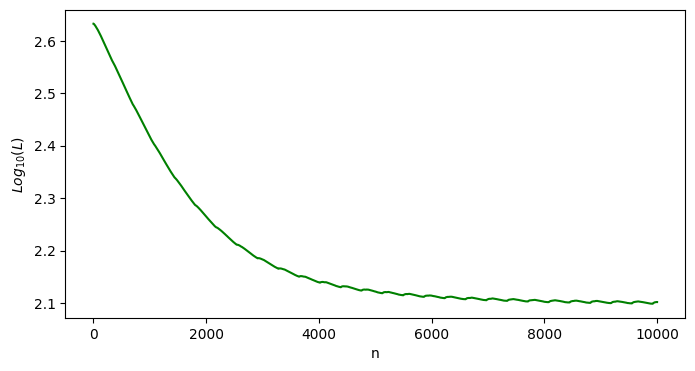

In [60]:
import matplotlib.pyplot as plt

import numpy as np

fig,ax = plt.subplots(figsize=(8,4))

loss_array = np.log10(np.array(loss_l))

ax.plot(np.arange(len(loss_array)),loss_array,'g-')

ax.set_ylabel('$Log_{10}(L)$')
ax.set_xlabel('n')

plt.show()

In [62]:
mykey = random.PRNGKey(1)

loss_l2,out_params2,out_hidden2 = train_character_lstm(train_data=training_data,
                                  seq_length=seq_length,
                                  hidden_size=512,
                                  mini_batch_size=30,
                                  learning_rate=0.01,
                                  total_steps=10000,
                                  initial_key=mykey) 

----
           g Hs.4bchbm1FM6Wqh8!9x9nLz6npBJ7nDc2!m0z;IwseDH:c”5BF37tpbnU2L2MiPUKis JyJ3c8?,r          
          niw6bC’Y.tqb8cat:VSINTvq?p“3WoBok1W5hro;”;oYtdQMr'I.0BFO”cc7'M;CEhwOQGI90!zqoF81          
                              tD,4;DX”se1u,PwTQe?’H”iw2WdmPUq1I:”3ZBH0                               
----
Loss: 429.0460	Relative: 100.0000
----
            the lengthful courage in the war. Undame a lament; dippares o’er I deap’d ample          
             own some lost; Greek his should happy breathes; her, whele great Achilles              
                            mustard to the fate; 23 The charms my megual                             
----
Loss: 267.2834	Relative: 62.2971
----
           their careful cheer.” May must resounts of armour, dildars in his hand approach           
          my soft, and thought consign; His carpet stay the but and charm’d heart?” Hungs           
                              return’s from his arm once need, O flows                         

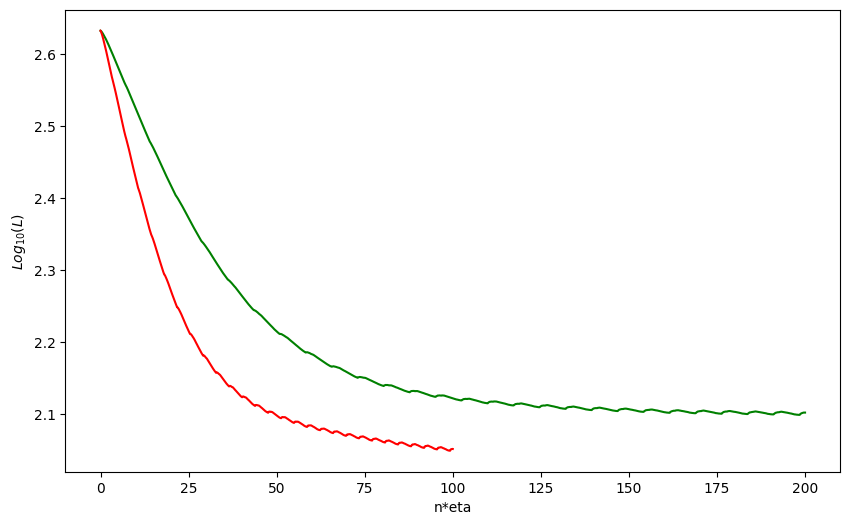

In [67]:
fig,ax = plt.subplots(figsize=(10,6))

loss_array1 = np.log10(np.array(loss_l))
loss_array2 = np.log10(np.array(loss_l2))

ax.plot(np.arange(len(loss_array1))*0.02,loss_array1,'g-')
ax.plot(np.arange(len(loss_array2))*0.01,loss_array2,'r-')

ax.set_ylabel('$Log_{10}(L)$')
ax.set_xlabel('n*eta')

plt.show()